# **<center><font style="color:rgb(100,109,254)">Module 8: Emotion Recognition + AI Filters</font> </center>**

<center>
    <img src='https://drive.google.com/uc?export=download&id=1ekabh-KWOZhj8UPjf5AbZLzQ767z52_T' width=800> 
    <br/>
    <a href='https://www.shutterstock.com/image-photo/emotion-detected-by-artificial-intelligence-ai-1898196328'>Image Credits</a>
</center>
    

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to Support Vector Machine Theory.*

- *Lesson 2: Train an Emotion Recognition SVM on FER Dataset.*

- *Lesson 3: Create your own Dataset for Emotion Recognition.*

- ***Lesson 4:* Create AI Filters With Emotion Recognition Based Triggers.** *(This Tutorial)*


**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [15]:
import os
import cv2
import pickle
import itertools
import numpy as np
import pandas as pd
import mediapipe as mp
from sklearn import svm
import matplotlib.pyplot as plt
from collections import deque 
from previous_lesson import detectFacialLandmarks, predictEmotion, extractKeypoints_v2
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.8.10.1, it should be 0.8.9.1


## **<font style="color:rgb(134,19,348)">Initialize the Face Landmarks Detection Model</font>**

After that, we will initialize the **`mp.solutions.face_mesh`** class and set up the **`mp.solutions.face_mesh.FaceMesh()`** function (for videos) with appropriate arguments as we have been doing in the previous lessons.

In [16]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Setup the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1,
                                         refine_landmarks=True, min_detection_confidence=0.8, 
                                         min_tracking_confidence=0.6)

## **<font style="color:rgb(134,19,348)">Initialize the Selfie Segmentation Model</font>**

Now we will initialize the Mediapipe's selfie segmentation class using the `mp.solutions.selfie_segmentation` function and then set up the `mp.solutions.selfie_segmentation.SelfieSegmentation()` function with the argument explained below: 

* **`model_selection`** - It can be either `0` or `1`. `0` to select a **general-purpose** model, and `1` to select a model more optimized for **landscape** images.

So there are two models for segmentation in mediapipe, bypassing in `0` you will be using the **general model** i.e. input is resized to: `256x256x3` (Height, width, columns) and bypassing `1` you will be using the **landscape model** i.e. input resized to: `144x256x3` (Height, width, columns).

**Note that** *you should select the type of model by taking into account the aspect ratio of the original image, although the landscape model is a bit faster. These models automatically resize the input image before passing it through the network and the size of the output image representing the segmentation mask for both models will be the same as the original input image.*

In [17]:
# Initializing mediapipe segmentation class.
mp_selfie_segmentation = mp.solutions.selfie_segmentation

# Setup up Segmentation function.
segment = mp_selfie_segmentation.SelfieSegmentation()

## **<font style="color:rgb(134,19,348)">Create a Segmentation Function</font>**


Now similar to what we had done in the previous modules, we will create a function **`performSegmentation()`** that will perform Mediapipe's Selfie Segmentation on an image and will visualize the resultant mask (created using a threshold value) along with the original image (using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library) or will return the resultant mask.

To perform the Selfie Segmentation, we will have to pass the image to the pipeline by using the function **`mp.solutions.selfie_segmentation.SelfieSegmentation().process()`**. But first, we will have to convert the image from **`BGR`** to **`RGB`** format using the function [**`cv2.cvtColor()`**](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) as OpenCV reads images in **`BGR`** format and the ml pipeline expects the input images to be in **`RGB`** color format.

The machine learning pipeline outputs an object that has an attribute **`segmentation_mask`** that contains a probability map with pixel values near `1` for the indexes where the person is located in the image and pixel values near `0` for the background. 

That's why we need to perform the thresholding as the model outputs some gray areas (values between 0 and 1) where it is not sure whether it is the background or the person. So using a threshold value, we will set all pixels above that value to white and all other pixels to black.

In [18]:
def performSegmentation(image, segment, threshold = 0.3, display = False):
    '''
    This function performs selfie segmentation on an image. 
    Args: 
        image:    The input image of person(s) whose background needs to be segmented.
        thresold: The threshold value between 0 and 1 which will be used in creating a binary mask of the input image.
        segment:  The Mediapipe's selfie segmentation function required to perform the segmentation.
        display:  A boolean value that is if set to true the function displays the original input image, 
                  and the resultant mask and returns nothing.
    Returns:
        binary_mask: The binary mask with values 0 (for background) and 1 (for person).
    '''
    
    # Convert the input image from BGR to RGB format.
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the segmentation.
    result = segment.process(RGB_img)
    
    # Get a binary mask having pixel value 1 for the person and 0 for the background.
    # Pixel values greater than the threshold value will become 1 and the remainings will become 0.
    binary_mask = result.segmentation_mask > threshold
    
    # Check if the original input image and the resultant mask are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant mask.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(binary_mask, cmap='gray');plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
        
        # Return the resultant mask.
        return binary_mask

Now we will read a few sample images using the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) and then utilize the function **`performSegmentation()`** created above to perform selfie segmentation on the images and display the results.

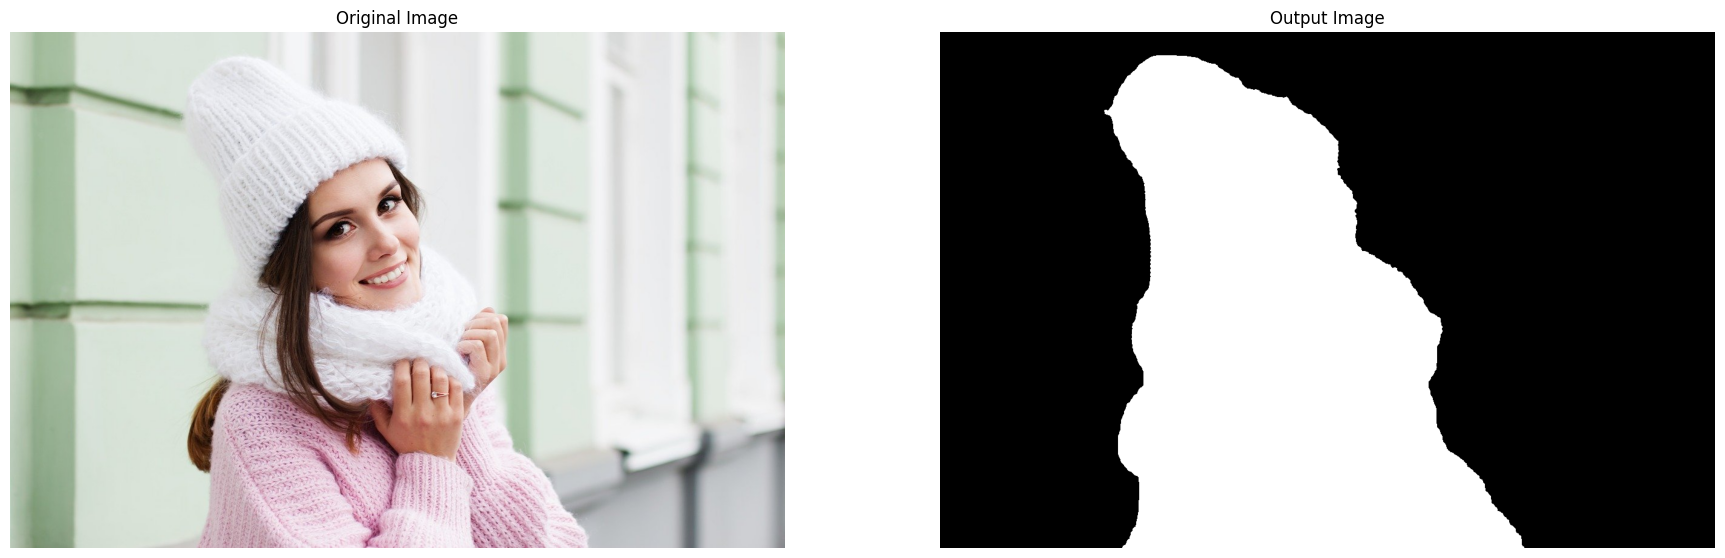

In [19]:
# Read a sample image and perform selfie segmentation on it.
image = cv2.imread('media/sample5.jpg')
performSegmentation(image, segment, display=True)

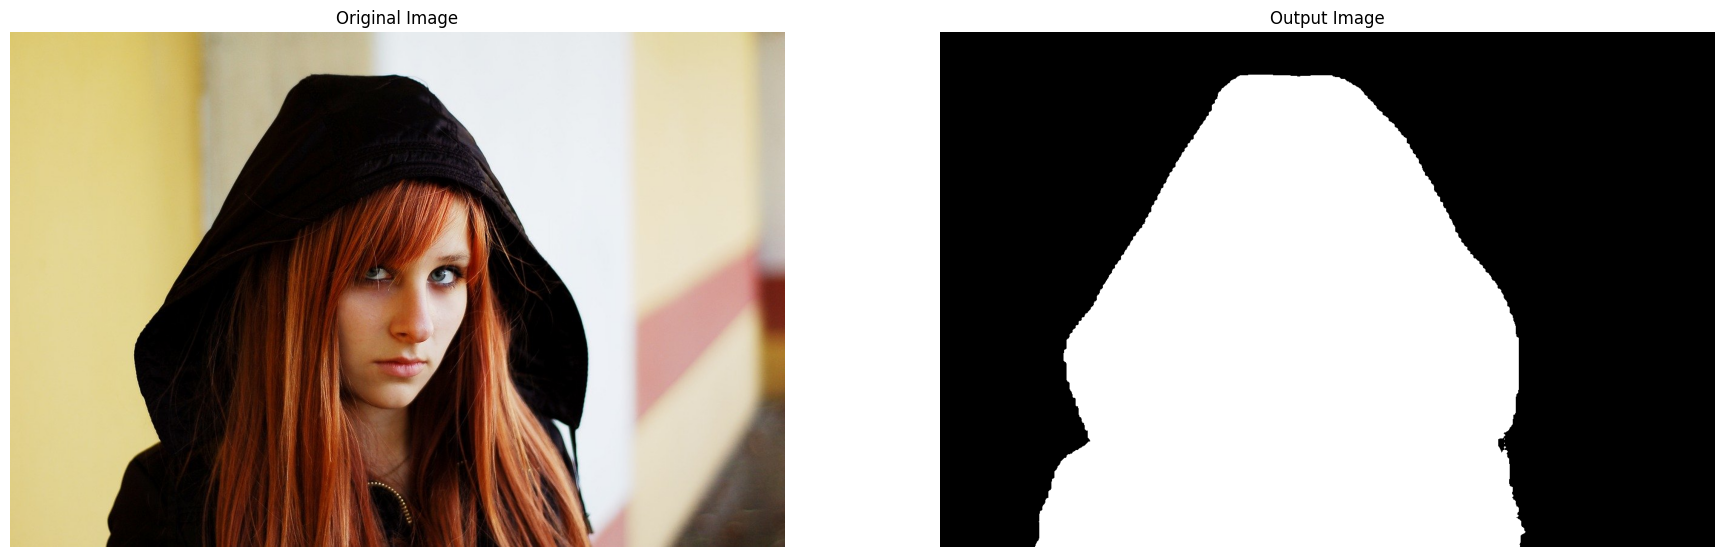

In [20]:
# Read another sample image and perform selfie segmentation on it.
image = cv2.imread('media/sample6.jpg')
performSegmentation(image, segment, display=True)

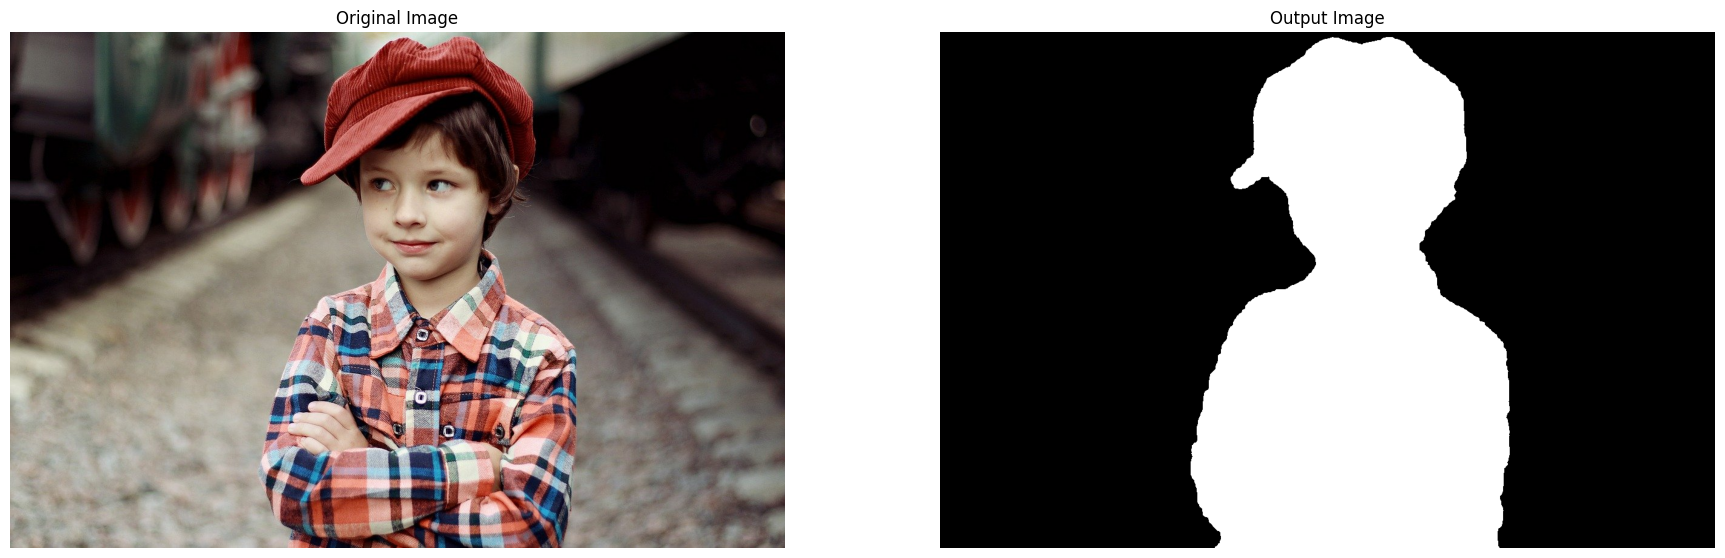

In [21]:
# Read another sample image and perform selfie segmentation on it.
image = cv2.imread('media/sample7.jpg')
performSegmentation(image, segment, display=True)

Cool! the results are satisfying.

## **<font style="color:rgb(134,19,348)">Create a Function to Apply Effect</font>**

Now let's move on and create a function **`applyEffect()`** that will utilize the `person_mask` returned by the function **`performSegmentation()`** to identify the background and foreground regions in the image and apply very interesting effects on the image based on the current expression (predicted by the SVM model we trained) of the person in the image in real-time.

In [22]:
def applyEffect(image, person_mask, expression, debugging=False, display=True):
    '''
    This function applies very interesting effects on a person image's background and foreground.
    Args:
        image:       An input image with a person in it.
        person_mask: A binary mask of the input image with `0` for background and `1` for foreground (person).
        expression:  The current predicted expression of the person in the image.
        debugging:   A boolean value that is if true the function displays the intermediate steps.
        display:     A boolean value that is if true the function displays the original input image and
                     the resultant image and returns nothing.
    Returns:
        output_image: The image with the effect applied, based on the person's expression.
    '''
    
    # Create copies of the input image.
    foreground = image.copy()
    background = image.copy()
    
    # Get the height and width of the image.
    image_height, image_width, _ = image.shape 
    
    # Initialize a variable to store the resultant image.
    output_image = image.copy()
    
    # Check if the expression of the person inside the image is 'anger'.
    if expression == 'anger':
    
        # Create an image with a single color (red).
        red_img  = np.full((image_height,image_width,3), (0,0,255), np.uint8)
        
        # Perform weighted addition between the red image and a copy of the input image. 
        foreground  = cv2.addWeighted(foreground, 0.9, red_img, 0.1, 0)
        
        # Convert a copy of the input image into grayscale.
        background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
        
        # Merge the image three times to make it a three-channel image.
        background = cv2.merge((background, background, background))
        
    # Check if the expression of the person inside the image is 'happiness'.
    elif expression == 'happiness':
        
        # Convert the input image into hsv color space.
        image_hsv = cv2.cvtColor(foreground, cv2.COLOR_BGR2HSV)
        
        # Convert the image into a float type array.
        image_hsv = np.array(image_hsv, dtype=np.float64)
        
        # Get the hue, saturation, and value channel of the image.
        hue_channel, saturation_channel, value_channel = cv2.split(image_hsv)
        
        # Multiple saturation channel with a scalar factor of 0.7.
        saturation_channel *= 0.7
        
        # Multiple value channel with a scalar factor of 1.5.
        value_channel *= 1.5
        
        # Merge the hue, saturation, and value channel.
        image_hsv = cv2.merge((hue_channel, saturation_channel, value_channel))
        
        # Set the values > 255 to 255.
        image_hsv[image_hsv > 255] = 255
        
        # Convert the image back to uint8 datatype and BGR color space.
        foreground =  cv2.cvtColor(np.array(image_hsv, dtype=np.uint8), cv2.COLOR_HSV2BGR) 
        
        # Set the blue channel of the image to 0.
        background[:,:,0] = 0
        
    # Check if the expression of the person inside the image is 'surprise'.   
    elif expression == 'surprise':
        
        # Apply a linear filter to the image.
        foreground = cv2.filter2D(src=foreground, 
                                  kernel=np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]),
                                  ddepth=-1)
        
        # Set the red channel of the image to 0.
        background[:,:,2] = 0
    
    # Update the foreground and background of the output image.
    output_image[person_mask==1] = foreground[person_mask==1]
    output_image[person_mask==0] = background[person_mask==0]
    
    # Check if the debugging mode is enabled.
    if debugging:
        
        # Display the intermediate steps.
        plt.figure(figsize=[15,15])
        plt.subplot(131);plt.imshow(person_mask, cmap='gray');plt.title("Person Mask");plt.axis('off');
        plt.subplot(132);plt.imshow(background[:,:,::-1]);plt.title("Background Image");plt.axis('off');
        plt.subplot(133);plt.imshow(foreground[:,:,::-1]);plt.title("Foreground Image");plt.axis('off');
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:
    
        # Return the resultant image.
        return output_image

Now let's check this **`applyEffect()`** function on a few sample images.

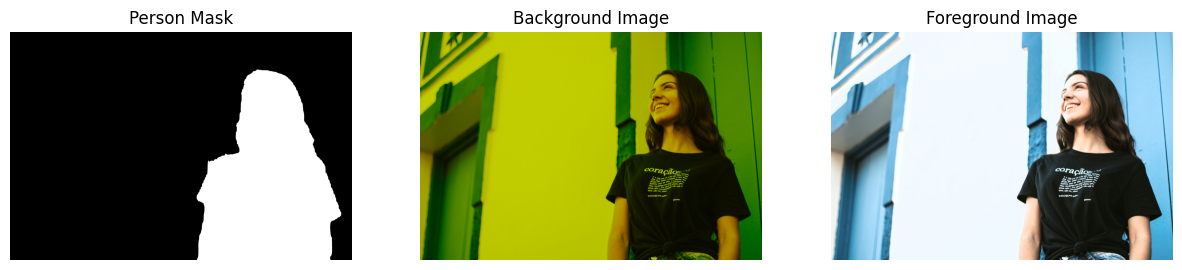

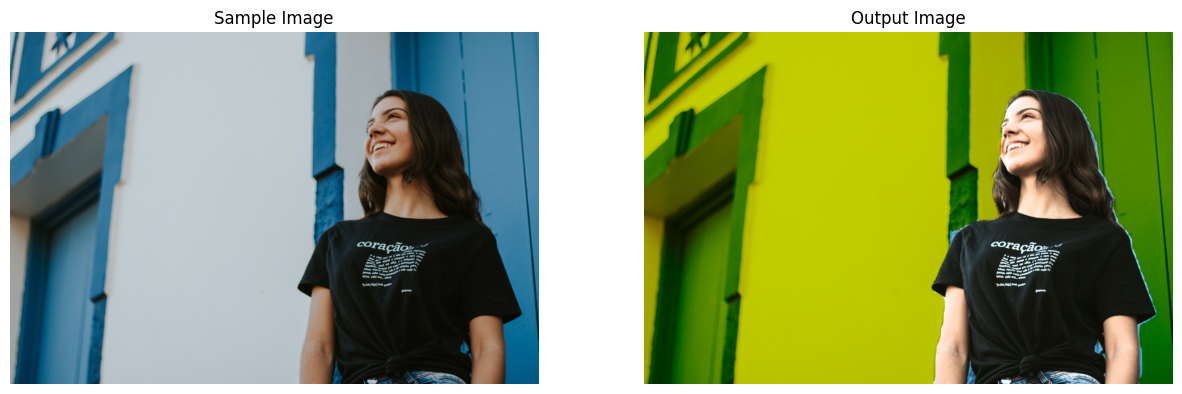

In [23]:
# Read a sample image and apply effect on it.
image = cv2.imread('media/sample1.jpg')
mask = performSegmentation(image, segment, display=False)
applyEffect(image, mask, expression='happiness', debugging=True, display=True)

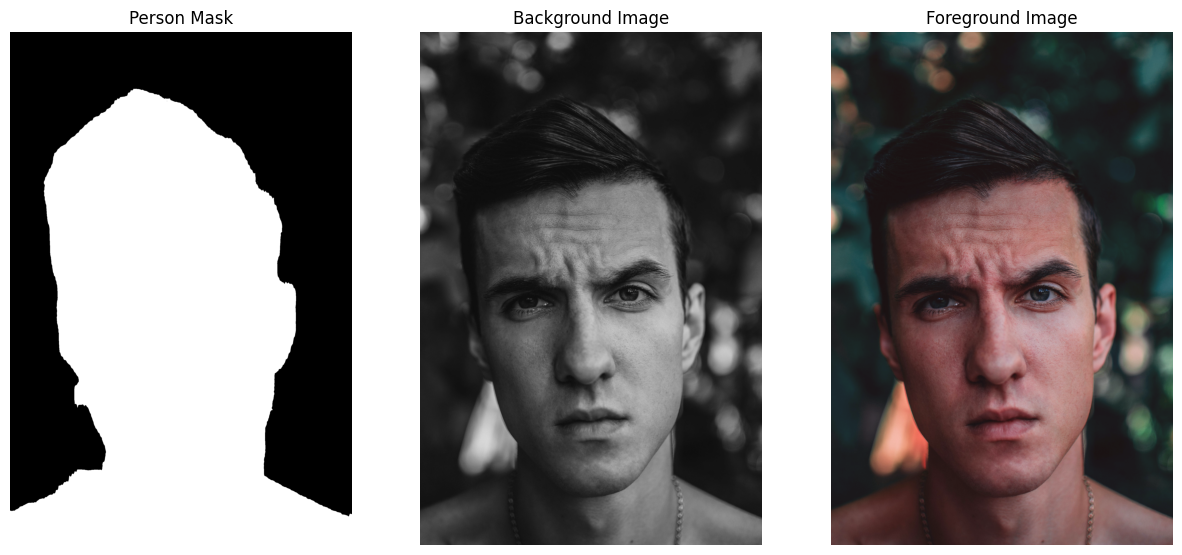

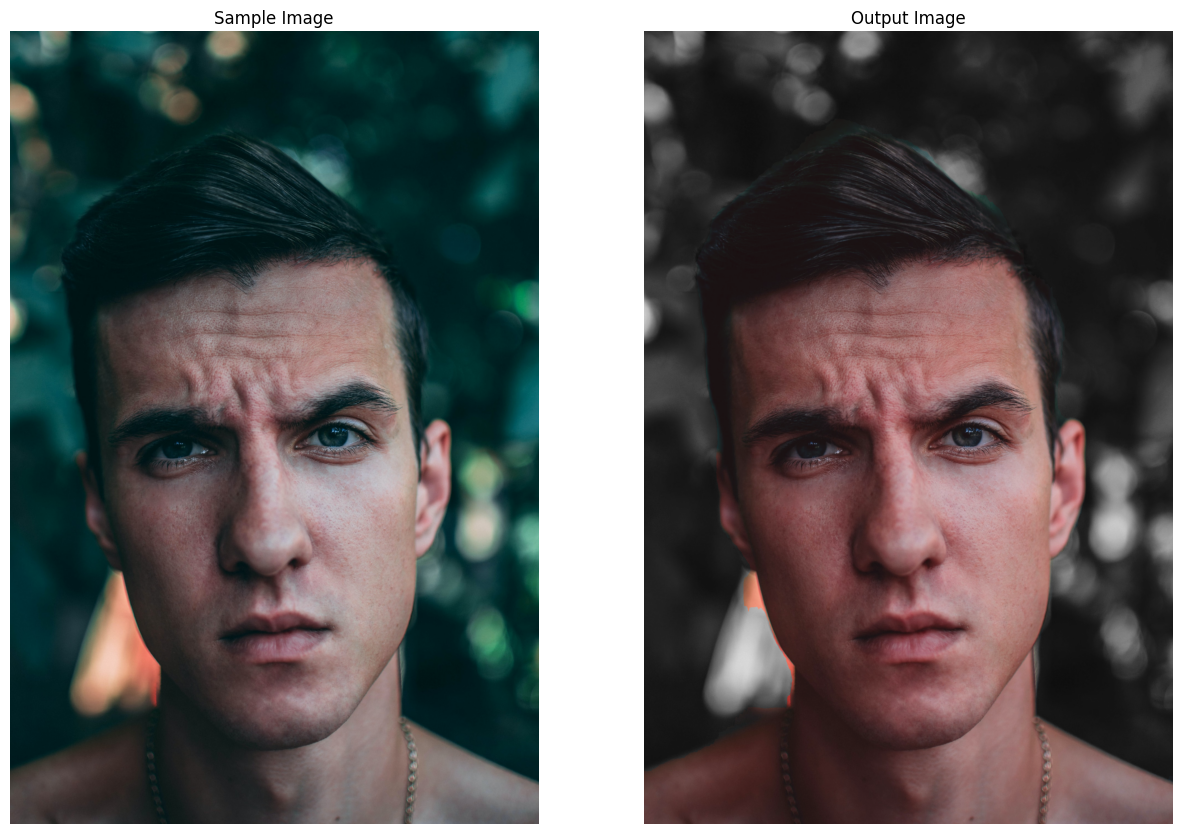

In [24]:
# Read another sample image and apply effect on it.
image = cv2.imread('media/sample2.jpg')
mask = performSegmentation(image, segment, display=False)
applyEffect(image, mask, expression='anger', debugging=True, display=True)

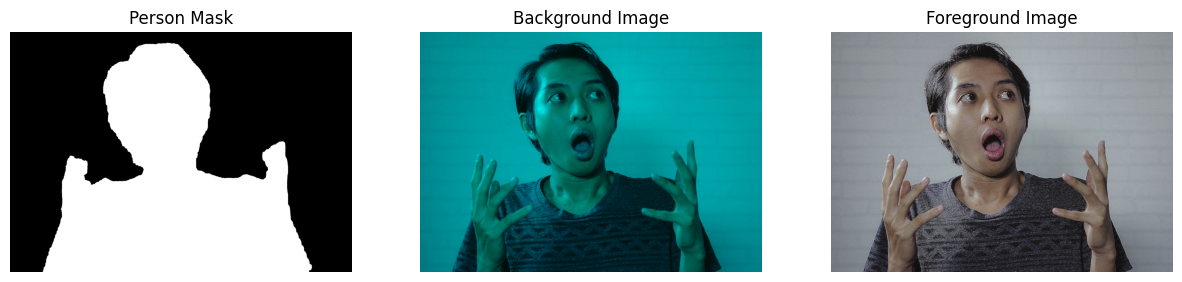

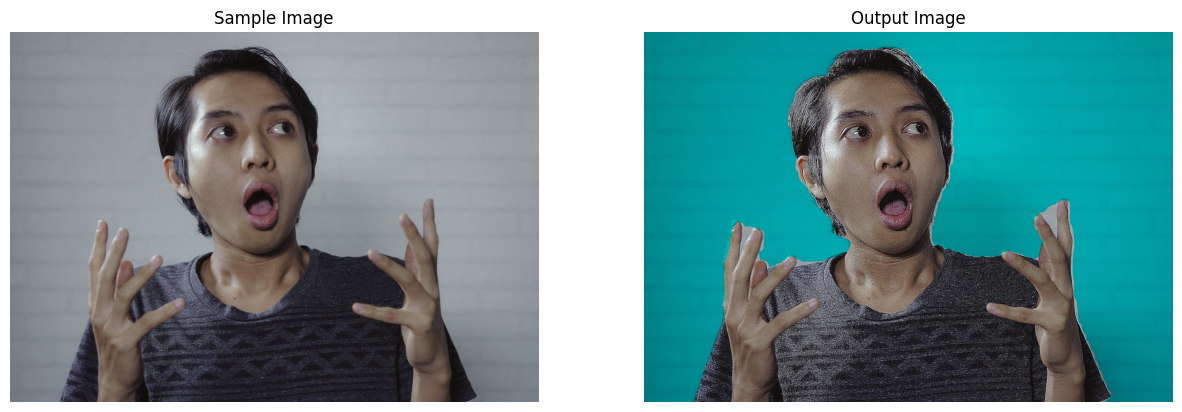

In [25]:
# Read another sample image and apply effect on it.
image = cv2.imread('media/sample3.jpg')
mask = performSegmentation(image, segment, display=False)
applyEffect(image, mask, expression='surprise', debugging=True, display=True)

Fascinating! right? but that's not all, we will also overlay a few animation videos over the frame of the webcam and the animations will change based on the current expression of the person in the frame, so let's move on to create the function that will help us serve the purpose.

## **<font style="color:rgb(134,19,348)">Create a Function to Overlay Animation</font>**

Now we will create a function **`overlayAnimation()`**, that will simply remove the black background of an animation image/frame using the function [**`cv2.inRange`**](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) and overlay the animation on top of the image/frame of a real-time webcam feed.

In [26]:
def overlayAnimation(image, animation_image, person_mask, lower_black=(0,0,0), upper_black=(180,255,30)):
    '''
    This function overlay a animation (after removing black background from it) over an image/frame.
    Args:
        image:           An input image with a person in it.
        animation_image: The image/frame of an animation video with black background.
        person_mask:     A binary mask of the input image with `0` for background and `1` for foreground (person).
        lower_black:     The lower threshold of the black color in HSV format.
        upper_black:     The upper threshold of the black color in HSV format.
    Returns:
        resultant_image: The image with the animation overlayed.
    '''
    
    # Get the height and width of the image.
    image_height, image_width, _ = image.shape    
    
    # Create a copy of the input image.
    image_copy = image.copy()
    
    # Resize the animation image to the input image size.
    animation_image = cv2.resize(animation_image, (image_width, image_height))
    
    # Convert the animation image into HSV color space.
    animation_imageHSV = cv2.cvtColor(animation_image, cv2.COLOR_BGR2HSV)
    
    # Create a mask of the animation image.
    # The mask will have pixel value 255 at the indexes where the black background is present in the animation image/frame.
    # And 0 at the remaining indexes.
    animation_mask = cv2.inRange(animation_imageHSV, lower_black, upper_black)
    
    # Invert the mask. This will convert the 0 into 255 and viceversa.
    animation_mask = ~animation_mask
    
    # Merge the mask three times to make it a three-channel image.
    animation_mask_3 = cv2.merge((animation_mask,animation_mask,animation_mask))
    
    # Overlay the animation on the input image.
    image_copy[animation_mask==255] = animation_image[animation_mask==255]
    
    # Perform weighted addition to get a transparent look for the overlayed animation.
    resultant_image = cv2.addWeighted(image, 0.2, image_copy, 0.8, 0)
    
    # Get the original image back for the indexes where the person is present.
    resultant_image[person_mask==1] = image[person_mask==1]
    
    # Return the resultant image.
    return resultant_image

## **<font style="color:rgb(134,19,348)">Build the Final Application</font>**

Now finally, we will put all the functions we have created together to combine Emotion Recognition with AI Filters and build the final application. The filters will be triggered based on the current expression of the person in the webcam feed in real-time.

In [27]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('AI Filters with Emotion Recognition', cv2.WINDOW_NORMAL)

# Initialize a list to store the animation videos info.
animations = []

# Create a function to restart an animation video.
def resetAnimation(animation_video, frame_counter):
    '''
    This function will restart an animation video.
    Args:
        animation_video: The opencv video capture object of the video that is to be restart.
        frame_counter:   The count of the current frame of the video.
    Returns:
        animation_video: The opencv video capture object of the video.
        frame_counter:   The count of the current frame of the video.
    '''
    
    # Increment the animation video frame counter.
    frame_counter += 1

    # Check if the current frame is the last frame of the animation video.
    if frame_counter == animation_video.get(cv2.CAP_PROP_FRAME_COUNT):     

        # Set the current frame position to first frame to restart the video.
        animation_video.set(cv2.CAP_PROP_POS_FRAMES, 0)

        # Set the animation video frame counter to zero.
        frame_counter = 0
    
    # Return the animation video capture object, and the frame counter.
    return animation_video, frame_counter

# Initialize a variable to store the buffer length.
BUFFER_MAX_LENGTH = 2

# Initialize a buffer to store predicted expressions.
buffer = deque([], maxlen=BUFFER_MAX_LENGTH)

# load the model from disk
loaded_model = pickle.load(open('model/face_expression_v2.sav', 'rb'))

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
   
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then 
    # continue to the next iteration to read the next frame.
    if not ok:
        continue
        
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Extract the required face keypoints of the person in the frame.
    face_landmarks = extractKeypoints_v2(frame, face_mesh_videos)
    
    # Check if the keypoints were extracted successfully.
    if len(face_landmarks) > 0:
    
        # Predict the face expression of the person inside the frame
        frame, current_expression = predictEmotion(frame, face_landmarks, loaded_model, 
                                                   threshold=0.9, draw=False, display=False)
        
        # Check if all the expressions stored in the buffer are equal to the current expression.   
        if all(expression==current_expression for expression in buffer):
            
            # Append the current expression into the buffer.
            buffer.append(current_expression)
        
        # Otherwise.
        else:
            
            # Clear the buffer.
            buffer.clear()

    # Otherwise.
    else:
        
        # Clear the buffer.
        buffer.clear()
        
    # Check if the length of the buffer is equal to the maxlength, that is 10.
    if len(buffer) == BUFFER_MAX_LENGTH:
        
        # Perform Selfie Segmentation on the frame.
        person_mask = performSegmentation(frame, segment, display=False)
        
        # Apply an effect on the frame's background and foreground based on the person's expression.
        frame = applyEffect(frame, person_mask, expression=max(buffer), display=False)
        
        # Write the predicted expression of the person on the frame.
        cv2.putText(frame, f'Prediction: {current_expression.upper()}', (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 2)
        
        # Check if the animations list length is equal to zero.
        if len(animations) == 0:
            
            # Check if the person's expression is 'happiness'.
            if max(buffer) == 'happiness':
                
                # Set the appropriate animations that we want to overlay.
                animations = [{'video': cv2.VideoCapture('media/heart_animation1.mp4'), 'frame_counter':0},
                              {'video': cv2.VideoCapture('media/heart.mp4'), 'frame_counter':0}]

            # Check if the person's expression is 'anger'.
            elif max(buffer) == 'anger':
                
                # Set the appropriate animation that we want to overlay.
                animations = [{'video': cv2.VideoCapture('media/fire_animation.mp4'), 'frame_counter':0}]

            # Check if the person's expression is 'surprise'.
            elif max(buffer) == 'surprise':
                
                # Set the appropriate animations that we want to overlay.
                animations = [{'video': cv2.VideoCapture('media/stars_animation.mp4'), 'frame_counter':0},
                              {'video': cv2.VideoCapture('media/christmas_animation.mp4'), 'frame_counter':0},
                              {'video': cv2.VideoCapture('media/snow_animation1.mp4'), 'frame_counter':0}]
            
        # Iterate over the animations.
        for animation in animations:
            
            # Read a frame of the animation we are iterating upon.
            _, animation_frame = animation['video'].read()
            
            # Restart the animation if we are on the last frame.
            animation['video'], animation['frame_counter'] = resetAnimation(animation['video'],
                                                                            animation['frame_counter'])
            
            # Overlay the animation on the frame.
            frame = overlayAnimation(frame, animation_frame, person_mask)
    
    # Otherwise.
    else:
        
        # Clear the animations.
        animations = []
    
    # Display the frame.
    cv2.imshow("AI Filters with Emotion Recognition", frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break
         
# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()


# Additional Comments:
#       - In summary, we use the selfie segmentation to
#         segment the detected person out of the frame.
#         Then, we apply filters on the background and foreground
#         depending on the person's expression.
#         After that, we merge the foreground and background
#         

Perfect! the application is working as we intended. 

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```

